In [35]:
import sys
import os
import statistics
import math
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from collections import defaultdict

In [2]:
sys.path.append("..")

In [3]:
from src.data import load_profiles, set_datapath

c:\Users\42190\.conda\envs\LB\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def get_item_profiles(profile_file: str):
    user_ids, item_ids = set(), set()
    profiles = defaultdict(list)

    with open(profile_file, "r") as df:
        for line in df:
            values = line.strip().split(" ")
            user_id, item_id = int(values[0]), int(values[1])
            user_ids.add(user_id)
            item_ids.add(item_id)
            profiles[item_id].append(user_id)

    return profiles

In [13]:
DATASET = "industrial_and_scientific"
MODE = "all"

In [14]:
os.makedirs(f"../analysis/{DATASET}/{MODE}", exist_ok=True)

In [15]:
set_datapath(f"../../data/{DATASET}")

In [16]:
user_ids, item_ids, user_profiles = load_profiles(f"profiles_{MODE}.txt")
item_profiles = get_item_profiles(f"../../data/{DATASET}/profiles_{MODE}.txt")

In [17]:
edges = set()

for k, v in user_profiles.items():
    for i in v:
        edges.add((k, i))

In [18]:
# Joint statistics
sparsity = len(edges) / (len(user_ids) * len(item_ids)) * 100
interactions = sum(len(p) for p in user_profiles.values())

In [19]:
# User statistics
multi_sess_u = sum(len(p) > 1 for p in user_profiles.values())
avg_u = statistics.mean(len(p) for p in user_profiles.values())
std_u = statistics.stdev(len(p) for p in user_profiles.values())
med_u = statistics.median(len(p) for p in user_profiles.values())
mod_u = statistics.mode(len(p) for p in user_profiles.values())
max_u = max(len(p) for p in user_profiles.values())
min_u = min(len(p) for p in user_profiles.values())

In [20]:
# Item statistics
multi_sess_i = sum(len(p) > 1 for p in item_profiles.values())
avg_i = statistics.mean(len(p) for p in item_profiles.values())
std_i = statistics.stdev(len(p) for p in item_profiles.values())
med_i = statistics.median(len(p) for p in item_profiles.values())
mod_i = statistics.mode(len(p) for p in item_profiles.values())
max_i = max(len(p) for p in item_profiles.values())
min_i = min(len(p) for p in item_profiles.values())

In [21]:
v_labels = list(range(1, 51))
v_counts = [sum(len(p) == i for p in user_profiles.values()) for i in range(1, 51)]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.bar(v_labels, v_counts)
ax.set(xlabel="Interactions per profile", ylabel="Number of profiles", title=DATASET.replace("_", " ").capitalize())
ax.set_xticks([i * 5 for i in range(11)])
ax.grid(linewidth=0.3)

In [23]:
fig.savefig(fname=f"../analysis/{DATASET}/{MODE}/user_dist.png")

In [24]:
i_labels = list(range(1, 51))
i_counts = [sum(len(p) == i for p in item_profiles.values()) for i in range(1, 51)]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.bar(i_labels, i_counts)
ax.set(xlabel="Interactions per item", ylabel="Number of items", title=DATASET.replace("_", " ").capitalize())
ax.set_xticks([i * 5 for i in range(11)])
ax.grid(linewidth=0.3)

In [26]:
fig.savefig(fname=f"../analysis/{DATASET}/{MODE}/item_dist.png")

In [27]:
# Popularity distribution of items
pop = sorted([len(p) for p in item_profiles.values()], reverse=True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(range(len(pop)), pop)
ax.set(xlabel="Item number", ylabel="Number of interactions", title=DATASET.replace("_", " ").capitalize())
# ax.set_xticks([i * 5 for i in range(11)])
ax.grid(linewidth=0.3)

In [29]:
fig.savefig(fname=f"../analysis/{DATASET}/{MODE}/popularity.png")

In [30]:
kvtable = {
    "users": len(user_ids),
    "items": len(item_ids),
    "interactions": interactions,
    "sparsity (%)": round(sparsity, 6),
    "avg_user": round(avg_u, 6),
    "std_user": round(std_u, 6),
    "med_user": med_u,
    "mod_user": mod_u,
    "max_user": max_u,
    "min_user": min_u,
    "avg_item": round(avg_i, 6),
    "std_item": round(std_i, 6),
    "med_item": med_i,
    "mod_item": mod_i,
    "max_item": max_i,
    "min_item": min_i,
}

In [31]:
with open(f"../analysis/{DATASET}/{MODE}/stats.json", "w") as f:
    f.write(json.dumps(kvtable))

In [147]:
id, sbert, onehot = [], [], []

with open(f"../results/{DATASET}/{MODE}/x_identity_id_dot/results_per_seqlen.txt", "r") as f:
    for l in f:
        vals = l.strip().split(" ")
        id.append((float(vals[0]), float(vals[1]), int(vals[2])))
with open(f"../results/{DATASET}/{MODE}/sbert_identity_all_dot/results_per_seqlen.txt", "r") as f:
    for l in f:
        vals = l.strip().split(" ")
        sbert.append((float(vals[0]), float(vals[1]), int(vals[2])))
with open(f"../results/{DATASET}/{MODE}/onehot_identity_all_dot/results_per_seqlen.txt", "r") as f:
    for l in f:
        vals = l.strip().split(" ")
        onehot.append((float(vals[0]), float(vals[1]), int(vals[2])))

In [148]:
merged = []

for t1, t2, t3 in zip(id, sbert, onehot):
    assert t1[2] == t2[2] == t3[2]
    merged.append((t1[2], t1[0], t1[1], t2[0], t2[1], t3[0], t3[1]))

In [149]:
df = pd.DataFrame(merged, columns=["seq_len", "id_HR", "id_NDCG", "sbert_HR", "sbert_NDCG", "onehot_HR", "onehot_NDCG"])

In [150]:
df["bin"] = pd.cut(df["seq_len"], [0, 5, 10, 15, 20, 25, 30])
df_means = df.groupby("bin").agg(["mean", "count", "sum"])
df_means.columns = df_means.columns.map('_'.join)
df_means = df_means.reset_index()

In [ ]:
ax = df_means.plot.bar(x="bin", y=["sbert_HR_mean", "onehot_HR_mean", "id_HR_mean"], label=["SBERT", "onehot", "ID"], rot=0, figsize=(10, 8))
_ = ax.set_yticks([round(i * 0.05, 2) for i in range(16)])
_ = ax.yaxis.grid(linewidth=0.3)
_ = ax.set_ylabel("HR@10")
_ = ax.set_xlabel("Sequence length")
_ = ax.set_title(f'{DATASET.replace("_", " ").capitalize()}')

In [154]:
ax.get_figure().savefig(f"../analysis/{DATASET}/{MODE}/HR_mean.png")

In [ ]:
ax = df_means.plot.bar(x="bin", y=["seq_len_count", "sbert_HR_sum", "onehot_HR_sum", "id_HR_sum"], label=["counts", "SBERT", "onehot", "ID"], rot=0, figsize=(10, 8))
_ = ax.set_yticks([round(i * 2500, 0) for i in range(13)])
_ = ax.yaxis.grid(linewidth=0.3)
_ = ax.set_ylabel("Number of samples / Total HR")
_ = ax.set_xlabel("Sequence length")
_ = ax.set_title(f'{DATASET.replace("_", " ").capitalize()}')

In [159]:
ax.get_figure().savefig(f"../analysis/{DATASET}/{MODE}/HR_counts.png")

In [ ]:
ax = df_means.plot.bar(x="bin", y=["sbert_NDCG_mean", "onehot_NDCG_mean", "id_NDCG_mean"], label=["SBERT", "onehot", "ID"], rot=0, figsize=(10, 8))
_ = ax.set_yticks([round(i * 0.05, 2) for i in range(11)])
_ = ax.yaxis.grid(linewidth=0.3)
_ = ax.set_ylabel("NDCG@10")
_ = ax.set_xlabel("Sequence length")
_ = ax.set_title(f'{DATASET.replace("_", " ").capitalize()}')

In [163]:
ax.get_figure().savefig(f"../analysis/{DATASET}/{MODE}/NDCG_mean.png")

In [19]:
table = []

for root, dirnames, filenames in os.walk('../analysis/Amazon/'):
    for fname in [f for f in filenames if f == "stats.json"]:
        with open(os.path.join(root, fname), "r") as src:
            stats = json.loads(src.read())

        # parts = root.split("\\") 
        parts = os.path.normpath(root).split(os.sep)
        name, mode = parts[-2], parts[-1]
        stats = {"name": name, "mode": mode} | stats

        if len(table) == 0:
            table.append(list(stats.keys()))
        
        table.append(list(stats.values()))

In [22]:
result_table = []
result_table.append(table[0].copy() + ["onehot_HR", "onehot_NDCG", "sbert_HR", "sbert_NDCG", "id_HR", "id_NDCG"])
dirs_to_look = ["onehot_identity_all_dot", "sbert_identity_all_dot", "x_identity_id_dot"]

for row in table[1:]:
    name, mode = row[0], row[1]
    basedir = f"../results/Amazon/{name}/{mode}"
    result_list = []

    for dir in dirs_to_look:
        csv = [f for f in os.listdir(f"{basedir}/{dir}") if f.endswith("csv")]
        assert len(csv) == 1, f"{basedir}/{dir}"

        with open(f"{basedir}/{dir}/{csv[0]}", "r") as src:
            results = src.readlines()
        
        test_results = results[-1].replace("\n", "").split(";")
        assert test_results[2] == "test", f"{basedir}/{dir}/{csv[0]}"

        hr, ndcg = float(test_results[-2]), float(test_results[-1])
        result_list.extend([hr, ndcg])
    
    result_table.append(row.copy() + result_list)

In [23]:
headers = result_table.pop(0)
df = pd.DataFrame(result_table, columns=headers)

In [24]:
df.insert(4, "user_item_ratio", df["users"] / df["items"])

In [25]:
pd.set_option('display.max_columns', None)

In [ ]:
df

In [38]:
df.to_excel("../analysis/stats.xlsx")

In [79]:
plt.rc('font', size=25)

In [62]:
# plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [64]:
plt.rcdefaults()

[]

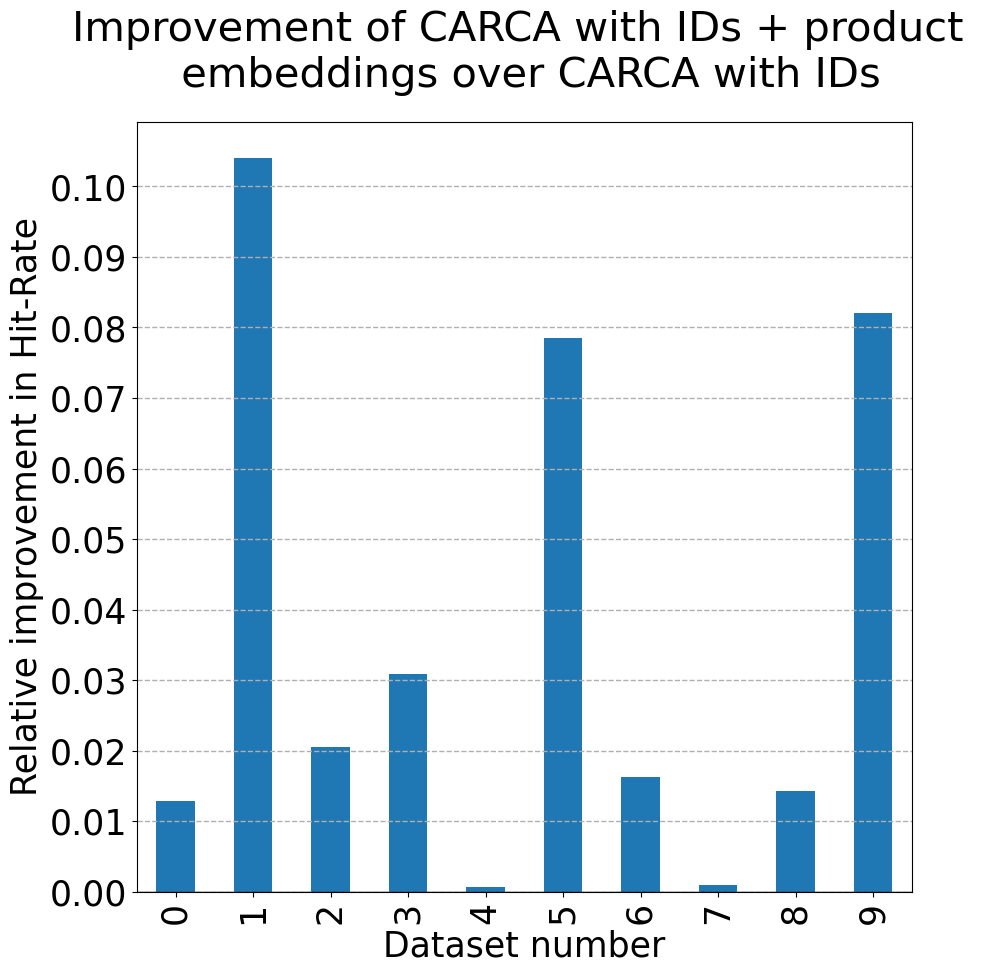

In [100]:
ax = (df["sbert_HR"] - df["id_HR"]).plot.bar(figsize=(10, 10))
ax.set_yticks([round(i * 0.01, 3) for i in range(-1, 13)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=1, linestyle='dashed')
ax.set_title("Improvement of CARCA with IDs + product \n embeddings over CARCA with IDs", pad=25)
ax.set_xlabel("Dataset number")
ax.set_ylabel("Relative improvement in Hit-Rate")
plt.plot()

In [104]:
# ax.get_figure().savefig(f"../analysis/sbert_vs_id_HR.png")
ax.get_figure().savefig(f"../analysis/sbert_vs_id_HR_big.png", transparent=True)

[]

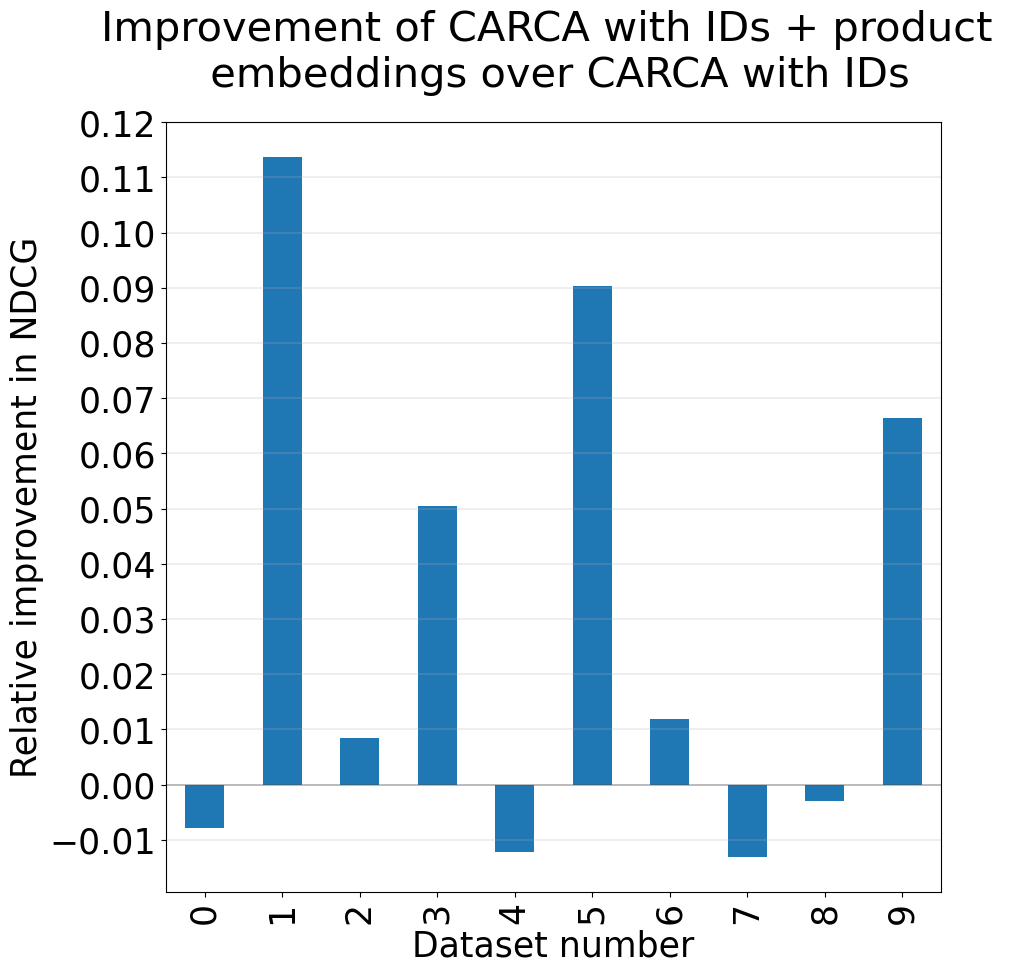

In [105]:
ax = (df["sbert_NDCG"] - df["id_NDCG"]).plot.bar(figsize=(10, 10))
ax.set_yticks([round(i * 0.01, 3) for i in range(-1, 13)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_title("Improvement of CARCA with IDs + product \n embeddings over CARCA with IDs", pad=25)
ax.set_xlabel("Dataset number")
ax.set_ylabel("Relative improvement in NDCG")
plt.plot()

In [106]:
# ax.get_figure().savefig(f"../analysis/sbert_vs_id_NDCG.png")
ax.get_figure().savefig(f"../analysis/sbert_vs_id_NDCG_big.png", transparent=True)

In [ ]:
ax = (df["sbert_HR"] - df["onehot_HR"]).plot.bar(figsize=(10, 10))
ax.set_yticks([round(i * 0.01, 3) for i in range(-1, 13)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_xlabel("Option")
ax.set_ylabel("SBERT improvement over onehot (HR)")

In [44]:
ax.get_figure().savefig(f"../analysis/sbert_vs_onehot_HR.png")

In [ ]:
ax = (df["sbert_NDCG"] - df["onehot_NDCG"]).plot.bar(figsize=(10, 10))
ax.set_yticks([round(i * 0.01, 3) for i in range(-1, 13)])
ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_xlabel("Option")
ax.set_ylabel("SBERT improvement over onehot (NDCG)")

In [46]:
ax.get_figure().savefig(f"../analysis/sbert_vs_onehot_NDCG.png")

In [148]:
plt.rc('font', size=25)

[]

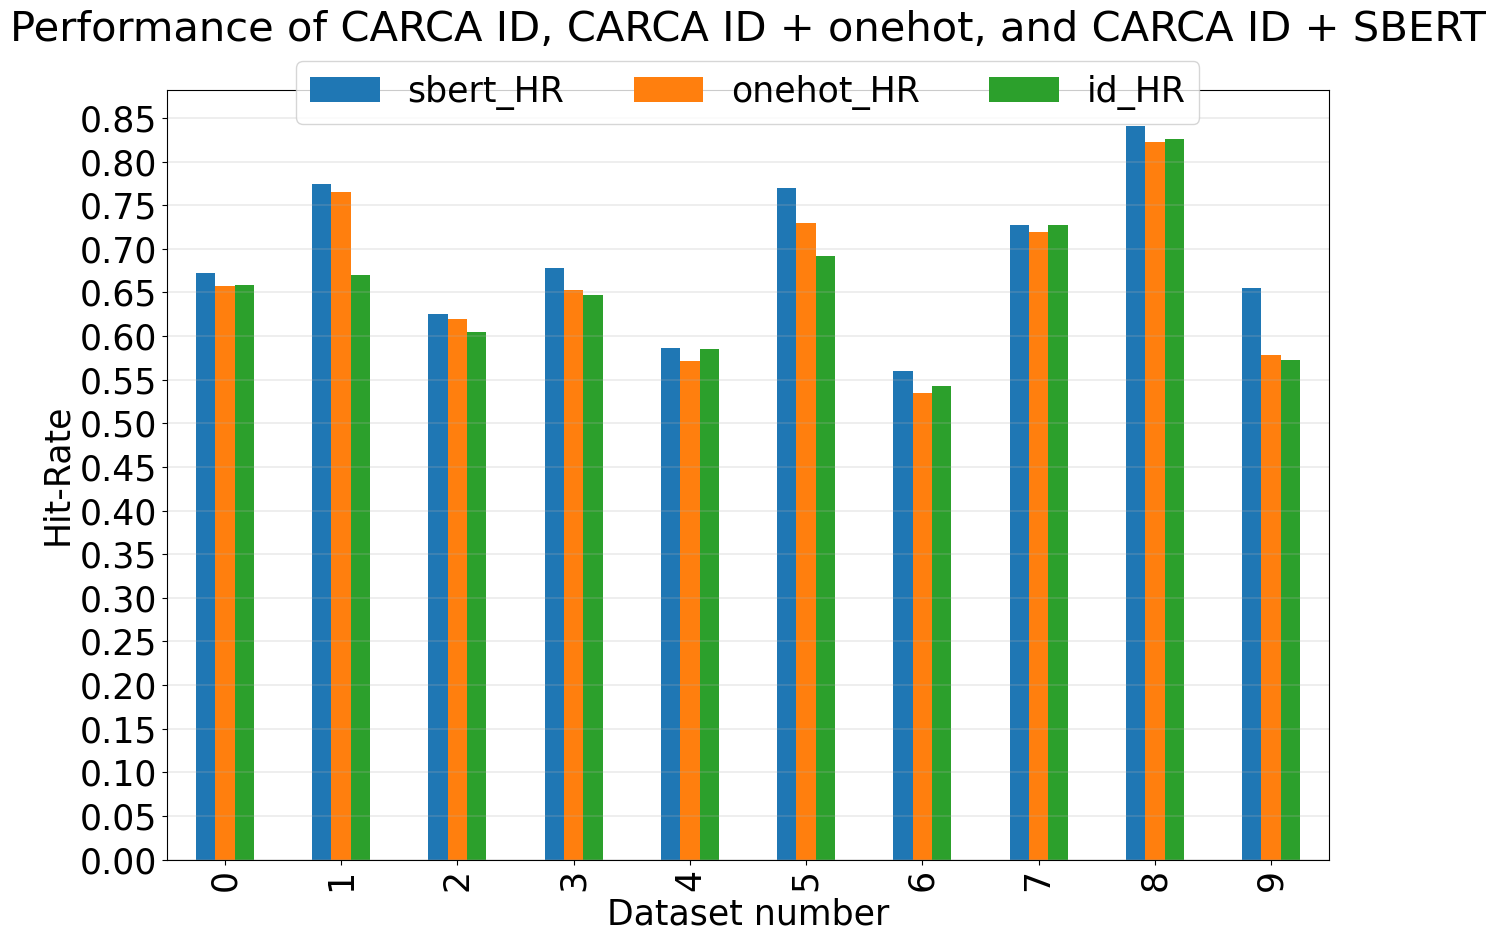

In [149]:
ax = df.reset_index().plot.bar(x="index", y=["sbert_HR", "onehot_HR", "id_HR"], figsize=(15, 10))
ax.set_yticks([round(i * 0.05, 2) for i in range(18)])
# ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=0.3)
ax.set_xlabel("Dataset number")
ax.set_ylabel("Hit-Rate")
ax.set_title("Performance of CARCA ID, CARCA ID + onehot, and CARCA ID + SBERT", pad=35)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=3)
plt.plot()

In [145]:
# ax.get_figure().savefig(f"../analysis/all_HR.png")
ax.get_figure().savefig(f"../analysis/all_HR_big.png", transparent=True, bbox_inches='tight')

In [171]:
plt.rc('axes', titlesize=25)

[]

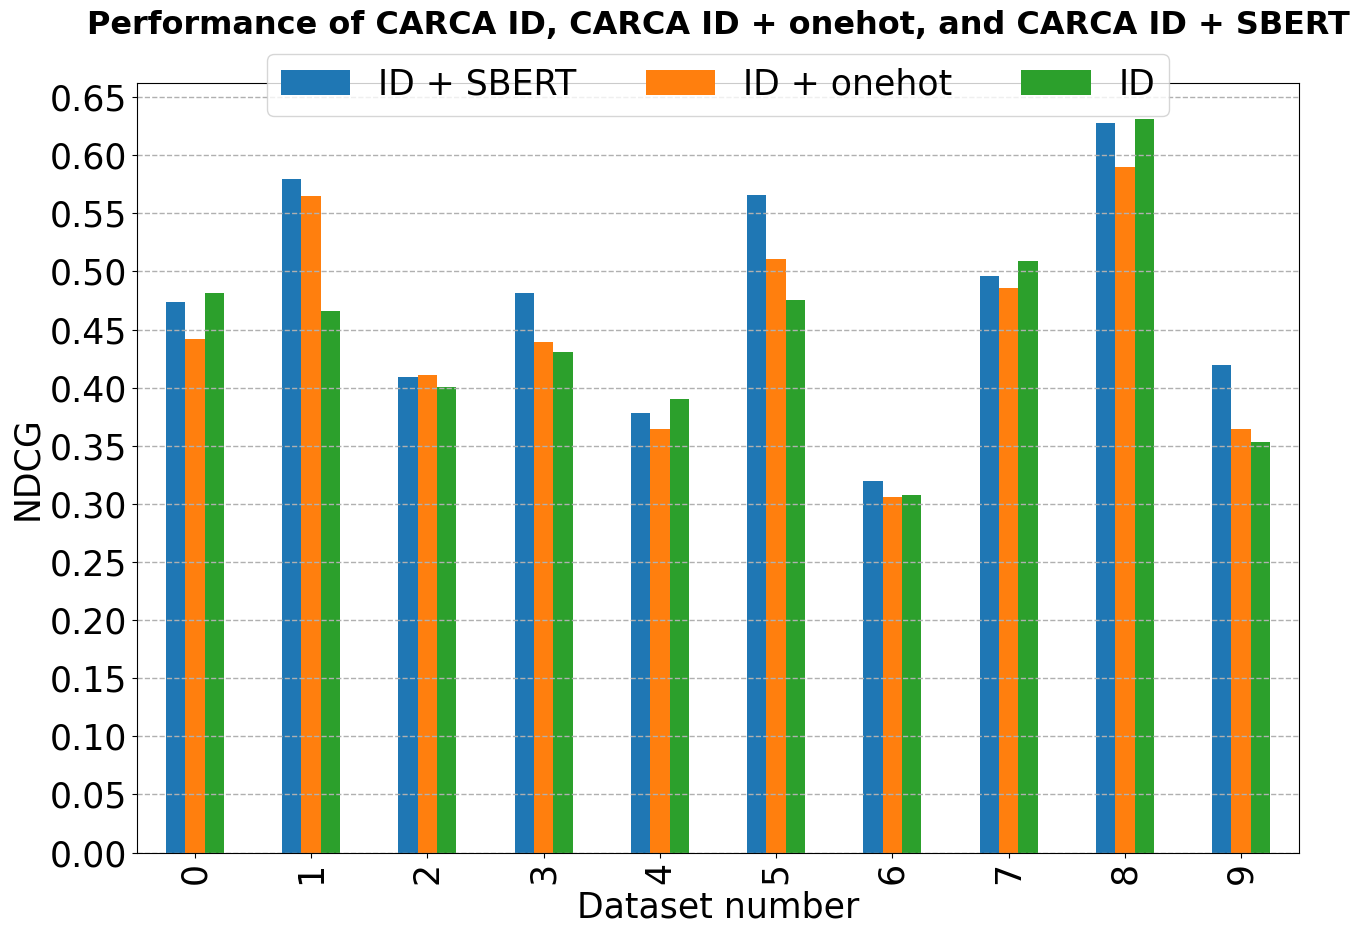

In [177]:
ax = df.reset_index().plot.bar(x="index", y=["sbert_NDCG", "onehot_NDCG", "id_NDCG"], figsize=(15, 10))
ax.set_yticks([round(i * 0.05, 2) for i in range(14)])
# ax.axhline(y=0.0, color="black", linewidth=0.3)
ax.yaxis.grid(linewidth=1, linestyle='dashed')
ax.set_xlabel("Dataset number")
ax.set_ylabel("NDCG")
ax.set_title("Performance of CARCA ID, CARCA ID + onehot, and CARCA ID + SBERT", pad=35, weight='bold')
ax.legend(["ID + SBERT", "ID + onehot", "ID"], loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=3)
plt.plot()

In [176]:
# ax.get_figure().savefig(f"../analysis/all_NDCG.png")
ax.get_figure().savefig(f"../analysis/all_NDCG_big.png", transparent=True, bbox_inches='tight')